In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tag import pos_tag
from nltk.stem.lancaster import LancasterStemmer 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim import corpora, models, matutils
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from corextopic import corextopic as ct
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("/Users/che-yuliu/Desktop/Metis_DSC_Bootcamp/NLP/Project/archive (1)/drugsComTrain_raw.csv")

In [3]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB
None


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.dropna()

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


[Text(0.5, 1.0, 'Ratings Distribution')]

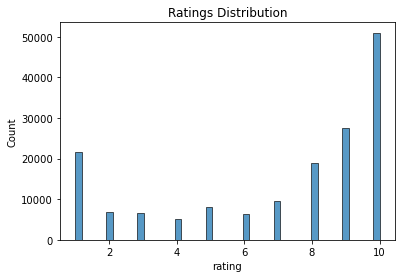

In [6]:
# Check distribution of rating and usefulcount 
sns.histplot(df["rating"]).set(title = "Ratings Distribution")

[Text(0.5, 1.0, 'Useful Count Distribution')]

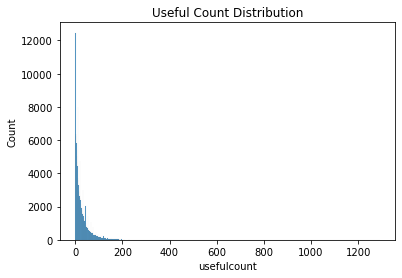

In [7]:
sns.histplot(df["usefulcount"]).set(title = "Useful Count Distribution")

In [8]:
df.loc[df["usefulcount"] == 0]

,uniqueid,drugname,condition,review,rating,date,usefulcount
16,48188,Trimethoprim,Urinary Tract Infection,"""This drug worked very well for me and cleared...",9,22-Sep-17,0
38,60678,MoviPrep,Bowel Preparation,"""I have taken this at least 5-6 times for the ...",2,29-Jun-17,0
45,111409,Ledipasvir / sofosbuvir,Hepatitis C,"""At initial testing my VL was over 6 million. ...",10,22-Sep-15,0
97,60280,NuvaRing,Birth Control,"""I am torn by the Nuvaring. The convenience is...",5,31-Oct-11,0
101,229524,Lurasidone,Schizophrenia,"""I&#039;ve been on Latuda for a little under 2...",8,26-Sep-15,0
...,...,...,...,...,...,...,...
161252,230002,Myobloc,Cervical Dystonia,"""I was given this for spasms in upper spine an...",1,22-Nov-17,0
161257,142183,Levonorgestrel,Birth Control,"""There are some bad reviews about Kyleena - so...",10,6-Dec-17,0
161273,109111,Nexplanon,Birth Control,"""I have had the Nexplanon since Dec. 27, 2016 ...",6,6-Apr-17,0
161276,176146,Lorazepam,Anxiety,"""About 4 years ago I started having early-morn...",8,21-Nov-17,0


__It seems like the most recent reviews have 0 people who have found the review useful__

In [9]:
# Converting date into a datetime object, I want to see if the it is the nature of a recent date causing 0 reviews. 
df["date"] = pd.to_datetime(df["date"])
df_date_sorted = df.sort_values(by = "date", ascending = False)
df_date_sorted

,uniqueid,drugname,condition,review,rating,date,usefulcount
5833,65582,Propranolol,mance Anxiety,"""I suffer from glossophobia or the fear of pub...",10,2017-12-12,0
8211,101565,Vaniqa,Hirsutism,"""I&#039;m thrilled with this product. After us...",10,2017-12-12,0
140284,160088,Rivaroxaban,Atrial Fibrillation,"""I made a comment here a couple of years ago w...",1,2017-12-12,0
1421,162659,Terconazole,Vaginal Yeast Infection,"""This is the meanest diabolical cream. Not sur...",1,2017-12-12,0
110317,21945,Infliximab,Rheumatoid Arthritis,"""I was diagnosed with Inflammatory Arthritis (...",10,2017-12-12,0
...,...,...,...,...,...,...,...
51387,100894,Orlistat,Obesity,"""Xenical really helped me, but some of the bow...",7,2008-02-24,50
137363,136265,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,"""I when to a medical clinic with flu like symp...",1,2008-02-24,0
67737,190771,Oxybutynin,Not Listed / Othe,"""Improved my problem dramatically. I never exp...",7,2008-02-24,22
52404,20345,Macrobid,Bladder Infection,"""Excellent for prevention of bladder infection...",8,2008-02-24,52


__It could be that towards the end of the 2017 not enough time was given for other users to take a look at the reviews so these will potentially be dropped from the overall dataset.__

In [10]:
# Dropping the rows that come after 2017
df_pre2017 = df_date_sorted.loc[(df['date'] < '2017')]

In [11]:
# Seems like there were about 30000 rows that were from 2017. 
df_pre2017

,uniqueid,drugname,condition,review,rating,date,usefulcount
110717,143555,Etonogestrel,Birth Control,"""So don&#039;t let the reviews deter you from ...",10,2016-12-31,4
157860,216354,Sildenafil,Erectile Dysfunction,"""I would have to say that viagra has really be...",10,2016-12-31,15
112358,50947,Azithromycin,Chlamydia Infection,"""I took it ate a burger and drank water.\r\r\...",9,2016-12-31,4
12287,156991,Movantik,"Constipation, Drug Induced","""I&#039;ve been a chronic pain patient for 13 ...",7,2016-12-31,19
38233,110878,Farxiga,"Diabetes, Type 2","""I&#039;ve been on this med for 3 months and t...",9,2016-12-31,26
...,...,...,...,...,...,...,...
51387,100894,Orlistat,Obesity,"""Xenical really helped me, but some of the bow...",7,2008-02-24,50
137363,136265,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,"""I when to a medical clinic with flu like symp...",1,2008-02-24,0
67737,190771,Oxybutynin,Not Listed / Othe,"""Improved my problem dramatically. I never exp...",7,2008-02-24,22
52404,20345,Macrobid,Bladder Infection,"""Excellent for prevention of bladder infection...",8,2008-02-24,52


In [12]:
# Creating a column using rating as a sentiment determiner
senttype = []
for rating in df["rating"]:
    if rating > 5: 
        rating = "pos"
        senttype.append(rating)
    else: 
        rating = "neg"
        senttype.append(rating)

In [13]:
df["senttype_rating"] = senttype

In [14]:
df

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,pos
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,pos
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,neg
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,pos
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,pos
...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125,pos
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34,neg
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35,neg
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79,pos


__Conducting Pre-processing of the reviews__ 

In [15]:
# Removing the quotations from the review column 
df["review"] = df["review"].apply(lambda x : x.replace('"', ''))


In [16]:
# Removing the weird patterns that have shown up "&#039;"
df["review"] = df["review"].apply(lambda x : x.replace("&#039;", "'"))

In [17]:
# Importing in stop words from nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/che-
[nltk_data]     yuliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Creating a variable for stop words 
stop_words = set(stopwords.words('english'))

In [19]:
# Removing stop words from the review
# Code obtained from https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
df["nostop_review"] = df["review"].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [20]:
# Creating stemmer objects
lanstem = LancasterStemmer()
snowstem = SnowballStemmer("english")

In [ ]:
# Trying out both stemmers 
# Lancasterstemmer
df["lanstem_review"] = df["nostop_review"].apply(lambda x: " ".join(lanstem.stem(word) for word in x.split()))

In [22]:
# Snowballstemmer 
df["snowstem_review"] = df["nostop_review"].apply(lambda x: " ".join(snowstem.stem(word) for word in x.split()))

In [23]:
df

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating,nostop_review,lanstem_review,snowstem_review
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,2012-05-20,27,pos,"It side effect, I take combination Bystolic 5 ...","it sid effect, i tak combin bystol 5 mg fish oil","it side effect, i take combin bystol 5 mg fish..."
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,2010-04-27,192,pos,My son halfway fourth week Intuniv. We became ...,my son halfway four week intuniv. we becam con...,my son halfway fourth week intuniv. we becam c...
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,2009-12-14,17,neg,"I used take another oral contraceptive, 21 pil...","i us tak anoth or contraceptive, 21 pil cycle,...","i use take anoth oral contraceptive, 21 pill c..."
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,2015-11-03,10,pos,This first time using form birth control. I'm ...,thi first tim us form bir control. i'm glad i ...,this first time use form birth control. i'm gl...
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,2016-11-27,37,pos,Suboxone completely turned life around. I feel...,suboxon complet turn lif around. i feel health...,suboxon complet turn life around. i feel healt...
...,...,...,...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,I wrote my first report in Mid-October of 2014...,10,2015-05-31,125,pos,I wrote first report Mid-October 2014. I alcoh...,i wrot first report mid-october 2014. i alcoho...,i wrote first report mid-octob 2014. i alcohol...
161293,127085,Metoclopramide,Nausea/Vomiting,I was given this in IV before surgey. I immedi...,1,2011-11-01,34,neg,I given IV surgey. I immediately became anxiou...,i giv iv surgey. i immedy becam anxy could sit...,i given iv surgey. i immedi becam anxious coul...
161294,187382,Orencia,Rheumatoid Arthritis,"Limited improvement after 4 months, developed ...",2,2014-03-15,35,neg,"Limited improvement 4 months, developed bad ra...","limit improv 4 months, develop bad rash md ref...","limit improv 4 months, develop bad rash md ref..."
161295,47128,Thyroid desiccated,Underactive Thyroid,"I've been on thyroid medication 49 years, I sp...",10,2015-09-19,79,pos,"I've thyroid medication 49 years, I spent firs...","i've thyroid med 49 years, i spent first 38 sy...","i'v thyroid medic 49 years, i spent first 38 s..."


__I will be moving forward with the SnowballStemmer as it seems less agressive with the stemming.__

In [24]:
# I will be removing all non A-Za-z or 0-9 characters from the stemmed list
df["clean_review"] = df.snowstem_review.str.replace(r"\W+", " ")

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_5278/4050115429.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["clean_review"] = df.snowstem_review.str.replace(r"\W+", " ")


In [25]:
df

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating,nostop_review,lanstem_review,snowstem_review,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,2012-05-20,27,pos,"It side effect, I take combination Bystolic 5 ...","it sid effect, i tak combin bystol 5 mg fish oil","it side effect, i take combin bystol 5 mg fish...",it side effect i take combin bystol 5 mg fish oil
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,2010-04-27,192,pos,My son halfway fourth week Intuniv. We became ...,my son halfway four week intuniv. we becam con...,my son halfway fourth week intuniv. we becam c...,my son halfway fourth week intuniv we becam co...
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,2009-12-14,17,neg,"I used take another oral contraceptive, 21 pil...","i us tak anoth or contraceptive, 21 pil cycle,...","i use take anoth oral contraceptive, 21 pill c...",i use take anoth oral contraceptive 21 pill cy...
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,2015-11-03,10,pos,This first time using form birth control. I'm ...,thi first tim us form bir control. i'm glad i ...,this first time use form birth control. i'm gl...,this first time use form birth control i m gla...
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,2016-11-27,37,pos,Suboxone completely turned life around. I feel...,suboxon complet turn lif around. i feel health...,suboxon complet turn life around. i feel healt...,suboxon complet turn life around i feel health...
...,...,...,...,...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,I wrote my first report in Mid-October of 2014...,10,2015-05-31,125,pos,I wrote first report Mid-October 2014. I alcoh...,i wrot first report mid-october 2014. i alcoho...,i wrote first report mid-octob 2014. i alcohol...,i wrote first report mid octob 2014 i alcohol ...
161293,127085,Metoclopramide,Nausea/Vomiting,I was given this in IV before surgey. I immedi...,1,2011-11-01,34,neg,I given IV surgey. I immediately became anxiou...,i giv iv surgey. i immedy becam anxy could sit...,i given iv surgey. i immedi becam anxious coul...,i given iv surgey i immedi becam anxious could...
161294,187382,Orencia,Rheumatoid Arthritis,"Limited improvement after 4 months, developed ...",2,2014-03-15,35,neg,"Limited improvement 4 months, developed bad ra...","limit improv 4 months, develop bad rash md ref...","limit improv 4 months, develop bad rash md ref...",limit improv 4 months develop bad rash md refu...
161295,47128,Thyroid desiccated,Underactive Thyroid,"I've been on thyroid medication 49 years, I sp...",10,2015-09-19,79,pos,"I've thyroid medication 49 years, I spent firs...","i've thyroid med 49 years, i spent first 38 sy...","i'v thyroid medic 49 years, i spent first 38 s...",i v thyroid medic 49 years i spent first 38 sy...


__Now that text processing is finished we will conduct sentiment analysis with VADER__

In [26]:
# initiating a vader object
analyzer = SentimentIntensityAnalyzer()
# Creating a function to get vader sentiment scores
def get_VADER(corpus): # <- takes in a pandas column, "corpus".
    # Iterating through each row in the column
    scores = []
    for doc in corpus:
        # Calling on the analyzer
        score = analyzer.polarity_scores(doc)["compound"]
        scores.append(score)
    return scores 

In [27]:
df["sentiment"] = get_VADER(df["clean_review"])

In [28]:
df

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating,nostop_review,lanstem_review,snowstem_review,clean_review,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,2012-05-20,27,pos,"It side effect, I take combination Bystolic 5 ...","it sid effect, i tak combin bystol 5 mg fish oil","it side effect, i take combin bystol 5 mg fish...",it side effect i take combin bystol 5 mg fish oil,0.0000
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,2010-04-27,192,pos,My son halfway fourth week Intuniv. We became ...,my son halfway four week intuniv. we becam con...,my son halfway fourth week intuniv. we becam c...,my son halfway fourth week intuniv we becam co...,0.8332
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,2009-12-14,17,neg,"I used take another oral contraceptive, 21 pil...","i us tak anoth or contraceptive, 21 pil cycle,...","i use take anoth oral contraceptive, 21 pill c...",i use take anoth oral contraceptive 21 pill cy...,-0.0000
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,2015-11-03,10,pos,This first time using form birth control. I'm ...,thi first tim us form bir control. i'm glad i ...,this first time use form birth control. i'm gl...,this first time use form birth control i m gla...,0.4199
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,2016-11-27,37,pos,Suboxone completely turned life around. I feel...,suboxon complet turn lif around. i feel health...,suboxon complet turn life around. i feel healt...,suboxon complet turn life around i feel health...,0.9382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,I wrote my first report in Mid-October of 2014...,10,2015-05-31,125,pos,I wrote first report Mid-October 2014. I alcoh...,i wrot first report mid-october 2014. i alcoho...,i wrote first report mid-octob 2014. i alcohol...,i wrote first report mid octob 2014 i alcohol ...,0.9709
161293,127085,Metoclopramide,Nausea/Vomiting,I was given this in IV before surgey. I immedi...,1,2011-11-01,34,neg,I given IV surgey. I immediately became anxiou...,i giv iv surgey. i immedy becam anxy could sit...,i given iv surgey. i immedi becam anxious coul...,i given iv surgey i immedi becam anxious could...,-0.4767
161294,187382,Orencia,Rheumatoid Arthritis,"Limited improvement after 4 months, developed ...",2,2014-03-15,35,neg,"Limited improvement 4 months, developed bad ra...","limit improv 4 months, develop bad rash md ref...","limit improv 4 months, develop bad rash md ref...",limit improv 4 months develop bad rash md refu...,-0.7351
161295,47128,Thyroid desiccated,Underactive Thyroid,"I've been on thyroid medication 49 years, I sp...",10,2015-09-19,79,pos,"I've thyroid medication 49 years, I spent firs...","i've thyroid med 49 years, i spent first 38 sy...","i'v thyroid medic 49 years, i spent first 38 s...",i v thyroid medic 49 years i spent first 38 sy...,0.9108


In [75]:
df.sort_values(by=["usefulcount"], ascending = False)

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating,nostop_review,lanstem_review,snowstem_review,clean_review,sentiment
6716,96616,Sertraline,Depression,"I remember reading people's opinions, online, ...",10,2008-07-31,1291,pos,"I remember reading people's opinions, online, ...","i rememb read people's opinions, online, drug ...","i rememb read peopl opinions, online, drug i t...",i rememb read peopl opinions online drug i too...,0.9055
33552,119152,Zoloft,Depression,"I remember reading people's opinions, online, ...",10,2008-07-31,1291,pos,"I remember reading people's opinions, online, ...","i rememb read people's opinions, online, drug ...","i rememb read peopl opinions, online, drug i t...",i rememb read peopl opinions online drug i too...,0.9055
21708,131116,Levonorgestrel,Birth Control,I have had my IUD for over a year now and I th...,10,2009-04-01,1247,pos,I IUD year I think best thing ever. When I fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever when i firs...,0.1591
4249,182560,Mirena,Birth Control,I have had my IUD for over a year now and I th...,10,2009-04-01,1247,pos,I IUD year I think best thing ever. When I fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever when i firs...,0.1591
146145,119151,Zoloft,Depression,I've been on Zoloft 50mg for over two years. I...,9,2008-08-05,949,pos,I've Zoloft 50mg two years. I relaxed easy-goi...,i've zoloft 50mg two years. i relax easy-going...,i'v zoloft 50mg two years. i relax easy-go per...,i v zoloft 50mg two years i relax easy go pers...,-0.2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27359,6895,Aluminum chloride hexahydrate,Hyperhidrosis,It only burns when putting on after shaving or...,10,2017-08-21,0,pos,It burns putting shaving excessive amounts. I ...,it burn put shav excess amounts. i us year nee...,it burn put shave excess amounts. i use year n...,it burn put shave excess amounts i use year ne...,0.5949
35698,168048,Imipramine,Depression,"I was on imipramine for a little over a year, ...",7,2017-11-13,0,pos,"I imipramine little year, trying every antidep...","i imipramin littl year, try every antidepress ...","i imipramin littl year, tri everi antidepress ...",i imipramin littl year tri everi antidepress k...,0.9543
35703,107357,Implanon,Birth Control,I received Implanon in May of 2008. I am due t...,5,2011-11-09,0,neg,I received Implanon May 2008. I due removed 6 ...,i receiv implanon may 2008. i due remov 6 mont...,i receiv implanon may 2008. i due remov 6 mont...,i receiv implanon may 2008 i due remov 6 month...,0.9403
92637,123484,Skyla,Birth Control,The only warning my gyno gave me was that I wo...,8,2017-10-17,0,pos,The warning gyno gave I would spotting 15 days...,the warn gyno gav i would spot 15 day iud inse...,the warn gyno gave i would spot 15 day iud ins...,the warn gyno gave i would spot 15 day iud ins...,0.0516


In [29]:
# Forgot to work on the dataframe with removed rows so fixing that now
df_clean = df.loc[(df['date'] < '2017')]

In [30]:
df_clean.sort_values(by=["usefulcount"], ascending = False)

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating,nostop_review,lanstem_review,snowstem_review,clean_review,sentiment
33552,119152,Zoloft,Depression,"I remember reading people's opinions, online, ...",10,2008-07-31,1291,pos,"I remember reading people's opinions, online, ...","i rememb read people's opinions, online, drug ...","i rememb read peopl opinions, online, drug i t...",i rememb read peopl opinions online drug i too...,0.9055
6716,96616,Sertraline,Depression,"I remember reading people's opinions, online, ...",10,2008-07-31,1291,pos,"I remember reading people's opinions, online, ...","i rememb read people's opinions, online, drug ...","i rememb read peopl opinions, online, drug i t...",i rememb read peopl opinions online drug i too...,0.9055
4249,182560,Mirena,Birth Control,I have had my IUD for over a year now and I th...,10,2009-04-01,1247,pos,I IUD year I think best thing ever. When I fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever when i firs...,0.1591
21708,131116,Levonorgestrel,Birth Control,I have had my IUD for over a year now and I th...,10,2009-04-01,1247,pos,I IUD year I think best thing ever. When I fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever. when i fir...,i iud year i think best thing ever when i firs...,0.1591
146145,119151,Zoloft,Depression,I've been on Zoloft 50mg for over two years. I...,9,2008-08-05,949,pos,I've Zoloft 50mg two years. I relaxed easy-goi...,i've zoloft 50mg two years. i relax easy-going...,i'v zoloft 50mg two years. i relax easy-go per...,i v zoloft 50mg two years i relax easy go pers...,-0.2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145290,214079,Tioconazole,Vaginal Yeast Infection,Worst product ever !!!! With all the horrible ...,1,2016-04-19,0,neg,Worst product ever !!!! With horrible reviews ...,"worst produc ev !!!! with horr review has, i u...",worst product ever !!!! with horribl review ha...,worst product ever with horribl review has i u...,0.4404
123082,227671,Etonogestrel,Birth Control,"Honestly, I have found this form of contracept...",10,2012-03-17,0,pos,"Honestly, I found form contraception great! Be...","honestly, i found form contraceiv great! bef i...","honestly, i found form contracept great! befor...",honestly i found form contracept great befor i...,0.9042
8163,142110,Escitalopram,Not Listed / Othe,I have been on Lexapro 10 mg for 1 month. I st...,3,2009-02-26,0,neg,I Lexapro 10 mg 1 month. I stopped taking time...,i lexapro 10 mg 1 month. i stop tak tim sid ef...,i lexapro 10 mg 1 month. i stop take time side...,i lexapro 10 mg 1 month i stop take time side ...,-0.1779
76296,19699,Pregabalin,ibromyalgia,I have been on pregabalin 75mg three a day for...,2,2011-08-17,0,neg,I pregabalin 75mg three day 3 months now. I fi...,i pregabalin 75mg three day 3 month now. i fib...,i pregabalin 75mg three day 3 month now. i fib...,i pregabalin 75mg three day 3 month now i fibr...,0.5106


__Keeping compound sentiment score as is because I want to see if level of sentiment mattered__

__Begin Topic Modeling__ 

In [31]:
# First thing to do is vectorize my text, using Countvectorizer 
reviews = df_clean["clean_review"]
cv = CountVectorizer()
X = cv.fit_transform(reviews)
cv_matrix = pd.DataFrame(X.toarray(), columns = cv.get_feature_names_out())

In [32]:
# Trying out LSA first.
lsa = TruncatedSVD(3)
lsa.fit(cv_matrix)

TruncatedSVD(n_components=3)

In [33]:
lsa.components_

array([[ 2.87990832e-03,  1.18519235e-03,  2.06222957e-06, ...,
         1.42272288e-05,  5.43622497e-06,  1.97008518e-06],
       [-2.35745770e-03, -4.64411031e-04, -9.86134787e-07, ...,
        -2.83631085e-05, -2.83009644e-06, -3.43354735e-06],
       [ 6.44349489e-04,  6.72737576e-04,  3.86752059e-06, ...,
        -3.15745792e-05,  5.55060100e-06, -1.38112775e-06]])

In [58]:
# Code obtained from https://www.youtube.com/watch?v=BJ0MnawUpaU&ab_channel=MikeBernico
terms = cv.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key = lambda x: x[1], reverse = True)[:20]
    print("Topic %d:" %i)
    for term in sorted_terms:
        print(term[0])
        print("")

Topic 0:
take

it

day

month

get

start

feel

side

week

time

year

work

pain

first

effect

like

the

my

pill

period

Topic 1:
period

month

pill

birth

control

weight

gain

get

first

got

week

bleed

acn

it

sex

mood

cramp

spot

my

skin

Topic 2:
day

period

week

pill

start

first

month

last

two

cramp

got

next

bleed

took

the

days

everi

felt

time

later



__Most common topics were about the pain/weight gain/time of side effects__ 

In [35]:
doc_topic = lsa.transform(cv_matrix)

In [71]:
doc_topic

array([[ 0.92345568, -0.55154169, -0.77993689],
       [ 3.20935485, -0.21467733,  1.03895473],
       [ 4.18883174,  1.66927903,  2.13752033],
       ...,
       [ 0.17027405,  0.03232158, -0.00554786],
       [ 2.47058074,  0.25957859, -1.00089302],
       [ 2.51538144,  0.09742842,  0.17544495]])

In [78]:
df_clean_sorted = df_clean.sort_values(by=["usefulcount"], ascending = False)

In [79]:
doc_topic_df = pd.DataFrame(doc_topic, index = df_clean_sorted["clean_review"])

In [80]:
doc_topic_df

,0,1,2
clean_review,,,
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,0.923456,-0.551542,-0.779937
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,3.209355,-0.214677,1.038955
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,4.188832,1.669279,2.137520
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,3.352868,1.946173,2.142340
i v zoloft 50mg two years i relax easy go person zoloft prior start medicine i anxious time worri constant everything suffer period depress hopelessness now i better wife friend person general,2.413067,-0.114321,-0.850434
...,...,...,...
worst product ever with horribl review has i understand still market i unfortun fell buy product suppos quot recommend doctors quot i must say night i insert gel cream insid me i thought vagina fire it 3 day sinc i v use it vagina soooo irrit soooo red look like someon took match burn inside do not buy this product go see a doctor and get antibiot better like diflucan,1.710021,0.692997,0.215495
honestly i found form contracept great befor insert i told everyon would experi differently 20 peopl get period i percentag first month i got mine it seem pretti light 4 day i seem bleed 11am 5pm weird that way bodi deal implanon in australia i paid 35 contracept last 3 years equal 90cent per month pretti good deal consid i previous pill 90 everi 3 months doctor the good profession ones should tell at least keep implanon 3 month 1 week,0.954847,0.185982,-0.626166
i lexapro 10 mg 1 month i stop take time side effect sleepless restless leg this near made imposs perform work i alway tire often late work it seem benefit modifi mood i abl keep near 6 month latest meltdown i tri effexor xr stop within 5 day side effect restless leg bare sleep inabl relax time,0.170274,0.032322,-0.005548


In [81]:
doc_topic_df['Primary_Topic'] = doc_topic_df.idxmax(axis=1)

In [82]:
doc_topic_df[:20]

,0,1,2,Primary_Topic
clean_review,,,,
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,0.923456,-0.551542,-0.779937,0
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,3.209355,-0.214677,1.038955,0
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,4.188832,1.669279,2.137520,0
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,3.352868,1.946173,2.142340,0
i v zoloft 50mg two years i relax easy go person zoloft prior start medicine i anxious time worri constant everything suffer period depress hopelessness now i better wife friend person general,2.413067,-0.114321,-0.850434,0
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.499280,-0.576868,1.178534,0
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.991605,0.308205,-0.176893,0
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,0.551803,-0.086729,0.073103,0
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,4.169926,0.648470,-1.430851,0


In [87]:
doc_topic_df['sentiment'] = list(df_clean_sorted["sentiment"])

In [90]:
doc_topic_df[:20]

,0,1,2,Primary_Topic,sentiment
clean_review,,,,,
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,0.923456,-0.551542,-0.779937,0,0.9055
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,3.209355,-0.214677,1.038955,0,0.9055
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,4.188832,1.669279,2.137520,0,0.1591
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,3.352868,1.946173,2.142340,0,0.1591
i v zoloft 50mg two years i relax easy go person zoloft prior start medicine i anxious time worri constant everything suffer period depress hopelessness now i better wife friend person general,2.413067,-0.114321,-0.850434,0,-0.2263
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.499280,-0.576868,1.178534,0,0.7964
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.991605,0.308205,-0.176893,0,0.7964
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,0.551803,-0.086729,0.073103,0,-0.9186
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,4.169926,0.648470,-1.430851,0,-0.9186


In [91]:
sent = []
for score in doc_topic_df["sentiment"]:
    if score >= 0.05: 
        rating = "pos"
        sent.append(rating)
    elif (score < 0.05) and (score > -0.05):
        rating = "neu"
        sent.append(rating)
    elif score <= -0.05: 
        rating = "neg"
        sent.append(rating)

In [93]:
doc_topic_df["sentiment"] = sent

In [95]:
doc_topic_df[:20]

,0,1,2,Primary_Topic,sentiment
clean_review,,,,,
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,0.923456,-0.551542,-0.779937,0,pos
i rememb read peopl opinions online drug i took scare away it then i final decid give tri best choic i made i 4 month i feel great i m 100mg i side effects when i first start i notic hand would trembl subsided so honestly listen negat work work amaz others so go base youself everyon else it may bless diguise the pill meant make happi go lucki see quot butterfli roses quot meant help put chemic mind balanc over depressed i still get sad times normal life peopl take control make change i get pill,3.209355,-0.214677,1.038955,0,pos
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,4.188832,1.669279,2.137520,0,pos
i iud year i think best thing ever when i first got put i bled week littl cramping after noth all i period 8month i final got one bad all it light cramping headache nothing i gain weight acn gone mood fine i know women different i hear horror stori i want tell story good one hope calm fears,3.352868,1.946173,2.142340,0,pos
i v zoloft 50mg two years i relax easy go person zoloft prior start medicine i anxious time worri constant everything suffer period depress hopelessness now i better wife friend person general,2.413067,-0.114321,-0.850434,0,neg
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.499280,-0.576868,1.178534,0,pos
i use pill past 9 years i say best pill lose weight onli thing ever work me i gain least 60 70 pound pregnancy time i child i massiv amount weight lose time i take pill i go right back size 4 within 4 5 month exercise my tips take long following alway take way breakfast tak first thing morning realli want get results eat carb breakfast never go take one day stopping will gain back you must wean slowli fine,2.991605,0.308205,-0.176893,0,pos
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,0.551803,-0.086729,0.073103,0,neg
i respond one week the side effect lethargy bowel problems reason didnt rate medicin 10 after 44 year excess anxieti depress i final feel like i quot myself quot instead enslav unreason thought frustrations ironically i avoid type med years instead quot self medicating quot alcohol cynicism had i switch year ago mayb i would still marri wonder woman sad true,4.169926,0.648470,-1.430851,0,neg
